Epoch 1/100
388/388 [==============================] - 4s 7ms/step - loss: 0.8815 - mae: 0.7453 - val_loss: 0.7349 - val_mae: 0.6824
Epoch 2/100
 17/388 [>.............................] - ETA: 2s - loss: 0.8147 - mae: 0.7173

/home/kb/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


388/388 [==============================] - 2s 6ms/step - loss: 0.7499 - mae: 0.6814 - val_loss: 0.7153 - val_mae: 0.6706
Epoch 3/100
388/388 [==============================] - 2s 5ms/step - loss: 0.7336 - mae: 0.6723 - val_loss: 0.7075 - val_mae: 0.6661
Epoch 4/100
388/388 [==============================] - 3s 7ms/step - loss: 0.7265 - mae: 0.6686 - val_loss: 0.7030 - val_mae: 0.6633
Epoch 5/100
388/388 [==============================] - 3s 7ms/step - loss: 0.7221 - mae: 0.6664 - val_loss: 0.7002 - val_mae: 0.6615
Epoch 6/100
388/388 [==============================] - 2s 6ms/step - loss: 0.7188 - mae: 0.6648 - val_loss: 0.6983 - val_mae: 0.6603
Epoch 7/100
388/388 [==============================] - 2s 5ms/step - loss: 0.7159 - mae: 0.6634 - val_loss: 0.6972 - val_mae: 0.6595
Epoch 8/100
388/388 [==============================] - 2s 6ms/step - loss: 0.7133 - mae: 0.6623 - val_loss: 0.6965 - val_mae: 0.6591
Epoch 9/100
388/388 [==============================] - 3s 7ms/step - loss: 0.7108

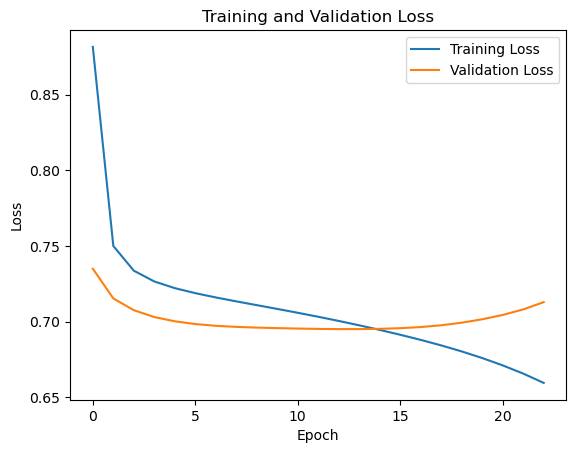

98/98 [==============================] - 0s 808us/step


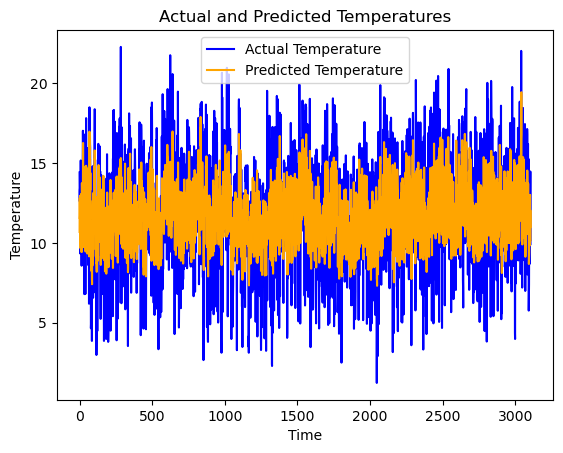

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load and preprocess the data
x = pd.read_csv("Cary_Weather_Data.csv")
x['DATE'] = pd.to_datetime(x[['YEAR', 'MONTH', 'DAY']])
x = x.drop(columns=['YEAR', 'MONTH', 'DAY'])
x = x[['DATE', 'Temperature', 'Humidity', 'Precipitation', 'Wind Speed']]
x.set_index('DATE', inplace=True)

# Scaling the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(x[['Temperature', 'Humidity', 'Precipitation', 'Wind Speed']])
scaled_features_df = pd.DataFrame(scaled_features, index=x.index, columns=['Temperature', 'Humidity', 'Precipitation', 'Wind Speed'])

# Define the create_dataset function
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Create the dataset with a larger time_steps window
time_steps = 10
X, y = create_dataset(scaled_features_df, scaled_features_df['Temperature'], time_steps)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

# Build the LSTM model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Add callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    shuffle=False
)

# Plot training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predictions
predicted = model.predict(X_val)
predicted = scaler.inverse_transform(np.concatenate((predicted, np.zeros((predicted.shape[0], 3))), axis=1))[:, 0]

# Actual values
actual = scaler.inverse_transform(np.concatenate((y_val.reshape(-1, 1), np.zeros((y_val.shape[0], 3))), axis=1))[:, 0]



In [3]:
%matplotlib qt
# Plot predictions against actual values
plt.figure()
plt.plot(actual, label='Actual Temperature', color='blue')
plt.plot(predicted, label='Predicted Temperature', color='orange')
plt.title('Actual and Predicted Temperatures')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()
